# Integration with databases

This example shows how to store the results of a pipeline to a database.

Contents:

- Integration with InfluxDB (time series).
- Integration with ElasticSearch (structured documents).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from videoanalytics.pipeline import Pipeline
from videoanalytics.pipeline.sources import VideoReader
from videoanalytics.pipeline.sinks import VideoWriter

We will be using the same video as in the previous examples.
Note: the video used in this example was downloaded from [youtube](https://www.youtube.com/watch?v=WgCe0tMO4lA).

In [3]:
DATA_PATH = "../data/"

# Input
INPUT_VIDEO = DATA_PATH+"/input/test_video.mp4"
START_FRAME = 8000
MAX_FRAMES = 100

In [4]:
%%HTML
<div style="text-align: center">
    <video width="600" height="400" controls>
      <source src="../data/input/test_video.mp4" type="video/mp4">
    </video>
</div>

In [5]:
# Output
OUTPUT_VIDEO = DATA_PATH+ "/output/test_output.avi"

We will be storing the detections for each frame in two formats:

- Object count of each class per frame as a time series (InfluxDB).
- Each detection as a record (ElasticSearch).

In [7]:
# Specific components for object detection
from videoanalytics.pipeline.sinks.object_detection import DetectionsAnnotator, DetectionsCSVWriter
from videoanalytics.pipeline.sinks.object_detection.yolo4 import YOLOv4DetectorTF

In [8]:
# Detector

# Object Detector model weights (Tensorflow)
DETECTOR_WEIGHTS_FILENAME = DATA_PATH+ "object_detection/checkpoints/yolov4-416-tf"
#DETECTOR_WEIGHTS_FILENAME = DATA_PATH+ "object_detection/checkpoints/yolov4-tiny-416"


# Classes names for Detections Annotator
DETECTOR_CLASSES_FILENAME = DATA_PATH+"object_detection/classes_definitions/coco.txt"

# CSV with Detections filename
DETECTIONS_FILENAME = DATA_PATH+"/output/detections.csv"

## Integration with InfluxDB

Two components are introduced: 
- `DetectionsCounter`: creates a variable named `<PREFIX><CLASS_ID><POSTFIX>` in the context with the number of instances for each class for each frame. (`<PREFIX>` and `<POSTFIX>` are parameters).
- `InfluxDBWriter`: writes the specified variables to InfluxDB.

In [13]:
from videoanalytics.pipeline.sinks.database.influxdb import InfluxDBWriter, DetectionsCounter

In [14]:
# 1. Create the global context
context = {}

# 2. Create the pipeline
pipeline = Pipeline()

# 3. Add components

# 3.1 Source
pipeline.add_component( VideoReader( "input",context,
                 video_path=INPUT_VIDEO,
                 start_frame=START_FRAME,
                 max_frames=MAX_FRAMES))

# 3.2 Detector
pipeline.add_component( YOLOv4DetectorTF("detector",context,weights_filename=DETECTOR_WEIGHTS_FILENAME) )

# 3.3 Detector to variable list
pipeline.add_component( DetectionsCounter("detcounter",
                                          context,
                                          classes_to_count=[0],
                                          prefix="OBJ_",
                                          postfix="_COUNT") )

# 3.4 InfluxDB
pipeline.add_component( InfluxDBWriter("influxdb",context,
                                        variables_to_publish=[
                                            "OBJ_00_COUNT"
                                        ], 
                                        host='localhost', 
                                        port=8086, 
                                        database="my_application",
                                        reset_db=True) )

# 3.5 Output video
pipeline.add_component(VideoWriter("writer",context,filename=OUTPUT_VIDEO))

In [15]:
# 4. Define connections
pipeline.set_connections([
    ("input", "detector"),
    ("detector", "detcounter"),
    ("detcounter", "influxdb"),
    ("influxdb", "writer")
])

In [16]:
pipeline.optimize()

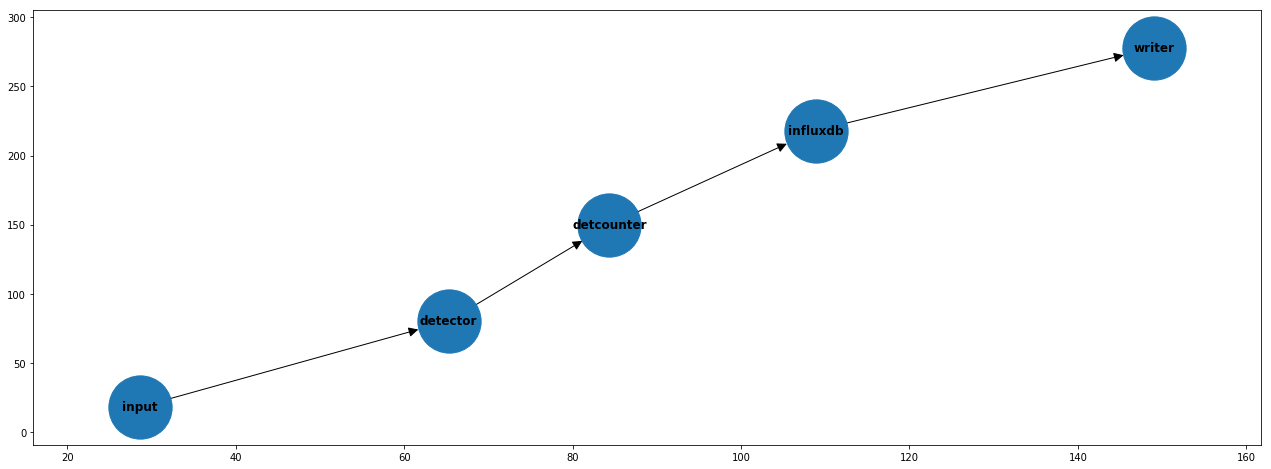

In [17]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,1,figsize=(22,8))
pipeline.plot(ax=axes)

In [18]:
# 5. Execute
pipeline.execute()
print("Total execution time [s]:", pipeline.get_total_execution_time())

  0%|          | 0/100.0 [00:00<?, ?it/s]

Total execution time [s]: 66.61873008300608


In [19]:
import pandas as pd

# 6. Report (optional)
metrics_df = pd.DataFrame.from_dict(pipeline.get_metrics(), orient='index',columns=["time [s]"])
metrics_df

,time [s]
input_avg_dt,0.011074
detector_avg_dt,0.518353
detcounter_avg_dt,0.000013
influxdb_avg_dt,0.087228
writer_avg_dt,0.045736


### Exploration of results

Statistics can be of interest to focus on frame from video that contain interesting events. This can also be performed with the CSV output, but storing the results in DB is the prefered method if scalability is a concern.

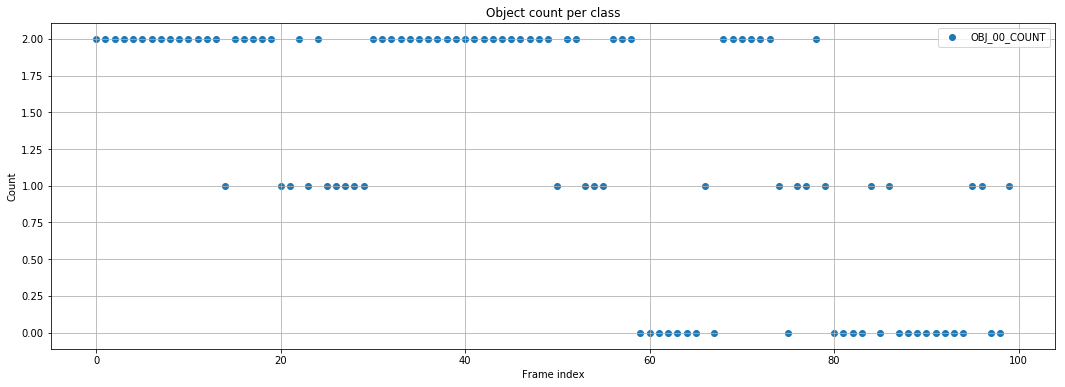

In [24]:
from videoanalytics.pipeline.sinks.database.influxdb import plot_timeseries
from influxdb import InfluxDBClient

INFLUXDB_HOSTNAME="localhost"
INFLUXDB_USERNAME="root"
INFLUXDB_PASSWORD="root"
INFLUXDB_SCHEMA="my_application"

client = InfluxDBClient( INFLUXDB_HOSTNAME, 8086, INFLUXDB_USERNAME, INFLUXDB_PASSWORD, INFLUXDB_SCHEMA)

variable_list = [
    "OBJ_00_COUNT"
]

fig,axes=plt.subplots(1,1,figsize=(18,6))    
plot_timeseries( client, variable_list,ax=axes,index_mode="index").set_title("Object count per class");     

## Integration with ElasticSearch

ElasticSearch is a Database designed for fast insertion and query of JSON documents. A typical application is to store events. In this case, a component is dedicated to store the detections in one step: `DetectionsESWriter`.

In [25]:
from videoanalytics.pipeline.sinks.database.elasticsearch import DetectionsESWriter

In [30]:
ELASTICSEARCH_HOSTNAME="localhost"
ELASTICSEARCH_INDEX="detections"

In [27]:
# 1. Create the global context
context = {}

# 2. Create the pipeline
pipeline = Pipeline()

# 3. Add components

# 3.1 Source
pipeline.add_component( VideoReader( "input",context,
                 video_path=INPUT_VIDEO,
                 start_frame=START_FRAME,
                 max_frames=MAX_FRAMES))

# 3.2 Detector
pipeline.add_component( YOLOv4DetectorTF("detector",context,weights_filename=DETECTOR_WEIGHTS_FILENAME) )

# 3.3 Detections writer
pipeline.add_component( DetectionsESWriter("eswriter",
                                           context,
                                           hostname=ELASTICSEARCH_HOSTNAME,
                                           es_index=ELASTICSEARCH_INDEX) )

# 3.6 Output video
pipeline.add_component(VideoWriter("writer",context,filename=OUTPUT_VIDEO))

# 4. Define connections
pipeline.set_connections([
    ("input", "detector"),
    ("detector", "eswriter"),
    ("eswriter", "writer")
])

# 5. Execute
pipeline.execute()
print("Total execution time [s]:", pipeline.get_total_execution_time())

  0%|          | 0/100.0 [00:00<?, ?it/s]

Total execution time [s]: 72.18773640099971


In [28]:
import pandas as pd

# 6. Report (optional)
metrics_df = pd.DataFrame.from_dict(pipeline.get_metrics(), orient='index',columns=["time [s]"])
metrics_df

,time [s]
input_avg_dt,0.011698
detector_avg_dt,0.525466
eswriter_avg_dt,0.132491
writer_avg_dt,0.048645


### Exploration of results

Advanced queries allow the identification of interesting sections of footage. Elasticsearch supports a query language with a similar syntax to SQL.

In [42]:
from elasticsearch import Elasticsearch

es = Elasticsearch(ELASTICSEARCH_HOSTNAME)

res = es.search(index=ELASTICSEARCH_INDEX, 
                body={
                    "query": {
                        "match_all": {
                            
                        }
                    }
                }
)

print("Got %d Hits:" % res['hits']['total']['value'])
for hit in res['hits']['hits']:
    print("%(timestamp)s Frame %(frame)s Class %(class_idx)s score: %(score)s" % hit["_source"])

Got 140 Hits:
2021-08-08T00:41:19.856067 Frame 8000 Class 0 score: 0.7429153323173523
2021-08-08T00:45:36.575191 Frame 8000 Class 0 score: 0.7429153323173523
2021-08-08T00:45:36.575191 Frame 8000 Class 0 score: 0.6205215454101562
2021-08-08T00:45:37.735088 Frame 8001 Class 0 score: 0.7429153323173523
2021-08-08T00:45:37.735088 Frame 8001 Class 0 score: 0.6205215454101562
2021-08-08T00:45:38.620463 Frame 8002 Class 0 score: 0.6578598618507385
2021-08-08T00:45:38.620463 Frame 8002 Class 0 score: 0.633901059627533
2021-08-08T00:45:39.363828 Frame 8003 Class 0 score: 0.6384348273277283
2021-08-08T00:45:39.363828 Frame 8003 Class 0 score: 0.5262541174888611
2021-08-08T00:45:40.171607 Frame 8004 Class 0 score: 0.6390221118927002
